### Machine Learning Applications for Health (COMP90089) Assignment 3: Cohort characterisation and clustering
#### 1132677 Yutong Chen
##### This jupyter notebook was editing and running locally. Please see the environment information in the yml file

## __________________________________________________________________________________________________________

### Load Data

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt


import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import display
from sklearn.manifold import TSNE

import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import IsolationForest

import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, confusion_matrix, log_loss
from sklearn.impute import SimpleImputer
import seaborn as sns


In [53]:
data = pd.read_csv('dka_apsiii_cci.csv')
data = data.dropna()
print(data.head())


    stay_id   hadm_id  subject_id gender  anchor_age           admit_time  \
0  35290845  21333517    16006168      M          20  2111-01-04T08:04:00   
1  31389801  22062066    16767959      M          40  2110-09-23T16:24:25   
2  35689140  27370071    11861582      M          44  2119-06-12T17:46:50   
3  31493334  27705504    15554295      M          46  2110-04-10T22:24:12   
4  37847825  27705504    15554295      M          46  2110-03-19T20:28:09   

        discharge_time       LoS  avg_heart_rate  avg_resp_rate  \
0  2111-01-05T12:15:25  1.174595       64.900000      13.250000   
1  2110-09-30T17:07:30  7.029919      110.673684      23.331579   
2  2119-06-17T14:13:13  4.851655       89.200000      18.142857   
3  2110-04-15T09:17:43  4.453831       74.518182      15.345455   
4  2110-03-23T18:07:29  3.902315       88.652632      19.031579   

   avg_temperature   avg_spo2  avg_hematocrit  avg_hemoglobin  avg_aniongap  \
0        98.471429  98.800000       39.900000       13.

### 1. Describe via summary statistics the main properties of the DKA patients

In [54]:
summary_stats = data[['anchor_age', 'gender', 'apsiii', 'LoS', 'charlson_comorbidity_index']].describe()
summary_stats.columns = ['Age of the patient (years)', 'Severity of illness scores (APSIII)', 'Length of stay in ICU', 'Co-morbidity index (Charlson)']
display(summary_stats)

,Age of the patient (years),Severity of illness scores (APSIII),Length of stay in ICU,Co-morbidity index (Charlson)
count,8847.000000,8847.000000,8847.000000,8847.000000
mean,64.905166,46.051882,3.878865,6.765457
std,14.003881,19.071723,5.299071,2.884668
min,18.000000,3.000000,0.025220,1.000000
25%,56.000000,32.000000,1.267870,5.000000
50%,66.000000,43.000000,2.175718,7.000000
75%,75.000000,56.000000,4.157153,9.000000
max,91.000000,167.000000,103.499005,20.000000


In [55]:
# Check the distribution of values in the 'developed_dka' column
dka_distribution = data['developed_dka'].value_counts()
dka_distribution

developed_dka
0    8347
1     500
Name: count, dtype: int64

C:\Users\ALLIED\AppData\Local\Temp\ipykernel_23412\727252811.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['gender'], ax=axes[4, 1], palette="Set2")
C:\Users\ALLIED\AppData\Local\Temp\ipykernel_23412\727252811.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['developed_dka'], ax=axes[5, 0], palette="Set2")


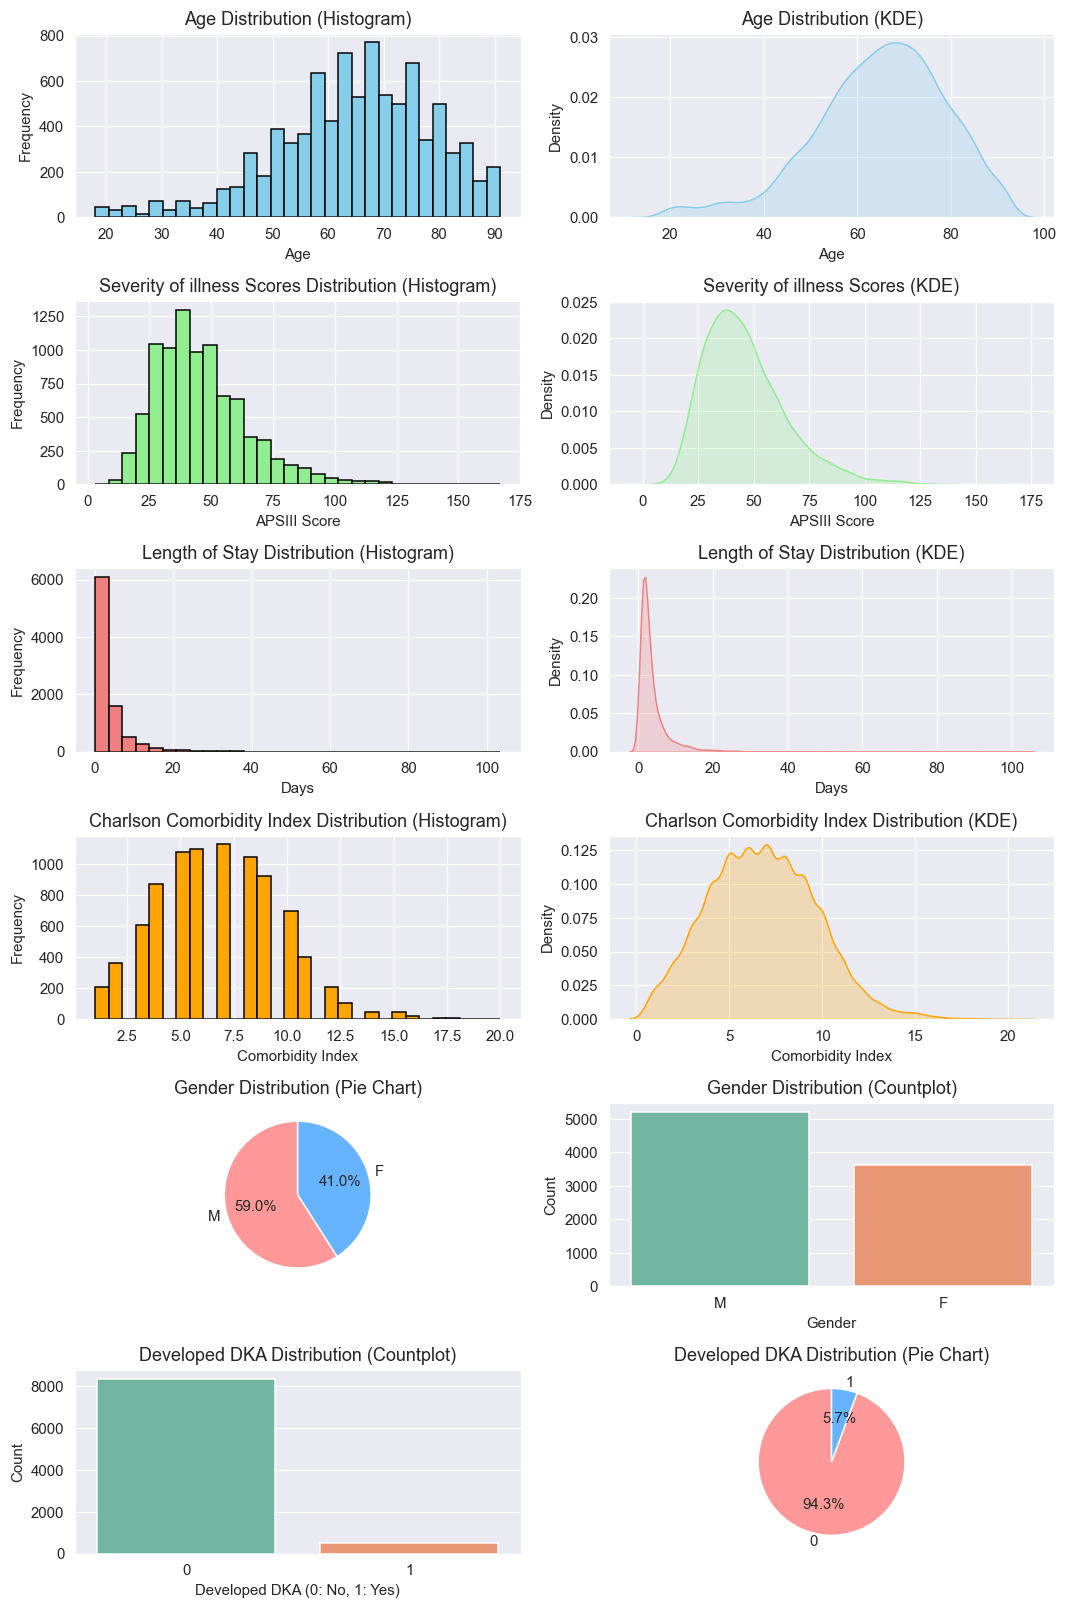

In [56]:
fig, axes = plt.subplots(6, 2, figsize=(10, 15))

# Row 1: Anchor age
# Histogram
axes[0, 0].hist(data['anchor_age'], bins=30, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Age Distribution (Histogram)')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Frequency')

# KDE
sns.kdeplot(data['anchor_age'], ax=axes[0, 1], fill=True, color='skyblue')
axes[0, 1].set_title('Age Distribution (KDE)')
axes[0, 1].set_xlabel('Age')

# Row 2: APSIII
# Histogram
axes[1, 0].hist(data['apsiii'], bins=30, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Severity of illness Scores Distribution (Histogram)')
axes[1, 0].set_xlabel('APSIII Score')
axes[1, 0].set_ylabel('Frequency')

# KDE
sns.kdeplot(data['apsiii'], ax=axes[1, 1], fill=True, color='lightgreen')
axes[1, 1].set_title('Severity of illness Scores (KDE)')
axes[1, 1].set_xlabel('APSIII Score')

# Row 3: LoS
# Histogram
axes[2, 0].hist(data['LoS'], bins=30, color='lightcoral', edgecolor='black')
axes[2, 0].set_title('Length of Stay Distribution (Histogram)')
axes[2, 0].set_xlabel('Days')
axes[2, 0].set_ylabel('Frequency')

# KDE
sns.kdeplot(data['LoS'], ax=axes[2, 1], fill=True, color='lightcoral')
axes[2, 1].set_title('Length of Stay Distribution (KDE)')
axes[2, 1].set_xlabel('Days')

# Row 4: Charlson Comorbidity Index
# Histogram
axes[3, 0].hist(data['charlson_comorbidity_index'], bins=30, color='orange', edgecolor='black')
axes[3, 0].set_title('Charlson Comorbidity Index Distribution (Histogram)')
axes[3, 0].set_xlabel('Comorbidity Index')
axes[3, 0].set_ylabel('Frequency')

# KDE
sns.kdeplot(data['charlson_comorbidity_index'], ax=axes[3, 1], fill=True, color='orange')
axes[3, 1].set_title('Charlson Comorbidity Index Distribution (KDE)')
axes[3, 1].set_xlabel('Comorbidity Index')

# Row 5: Gender
gender_counts = data['gender'].value_counts()
# Pie chart for gender
axes[4, 0].pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', colors=['#ff9999','#66b3ff'], startangle=90)
axes[4, 0].set_title('Gender Distribution (Pie Chart)')

# Countplot for gender
sns.countplot(x=data['gender'], ax=axes[4, 1], palette="Set2")
axes[4, 1].set_title('Gender Distribution (Countplot)')
axes[4, 1].set_xlabel('Gender')
axes[4, 1].set_ylabel('Count')

# Row 6: Developed DKA
# Countplot for developed_dka
sns.countplot(x=data['developed_dka'], ax=axes[5, 0], palette="Set2")
axes[5, 0].set_title('Developed DKA Distribution (Countplot)')
axes[5, 0].set_xlabel('Developed DKA (0: No, 1: Yes)')
axes[5, 0].set_ylabel('Count')

# Pie chart for DKA
dka_counts = data['developed_dka'].value_counts()
axes[5, 1].pie(dka_counts, labels=dka_counts.index, autopct='%1.1f%%', colors=['#ff9999','#66b3ff'], startangle=90)
axes[5, 1].set_title('Developed DKA Distribution (Pie Chart)')



plt.tight_layout()
plt.show()


### 2. Data Analysis and Clustering

In [57]:
# Import necessary libraries
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, learning_curve, LearningCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, cross_validate
from imblearn.under_sampling import RandomUnderSampler

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
import seaborn as sns
import matplotlib.pyplot as plt


#### Feature Selection

In [58]:
# Train a random forest model using all available features (excluding irrelevant ones)
X = data.drop(columns=['subject_id', 'hadm_id', 'admit_time', 'discharge_time', 'gender', 
                                    'stay_id', 'developed_dka'])
y = data['developed_dka']


# Train a new random forest model to extract feature importances
model_full = RandomForestClassifier(random_state=42)
model_full.fit(X, y)

# Extract feature importances
feature_importances = model_full.feature_importances_
feature_names = X.columns

# Create a DataFrame for feature importance scores
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

importance_df

,Feature,Importance
0,anchor_age,0.184685
9,avg_bicarbonate,0.141831
10,charlson_comorbidity_index,0.096275
5,avg_spo2,0.078135
6,avg_hematocrit,0.065937
8,avg_aniongap,0.064918
3,avg_resp_rate,0.064856
1,LoS,0.064420
2,avg_heart_rate,0.064028
7,avg_hemoglobin,0.062226


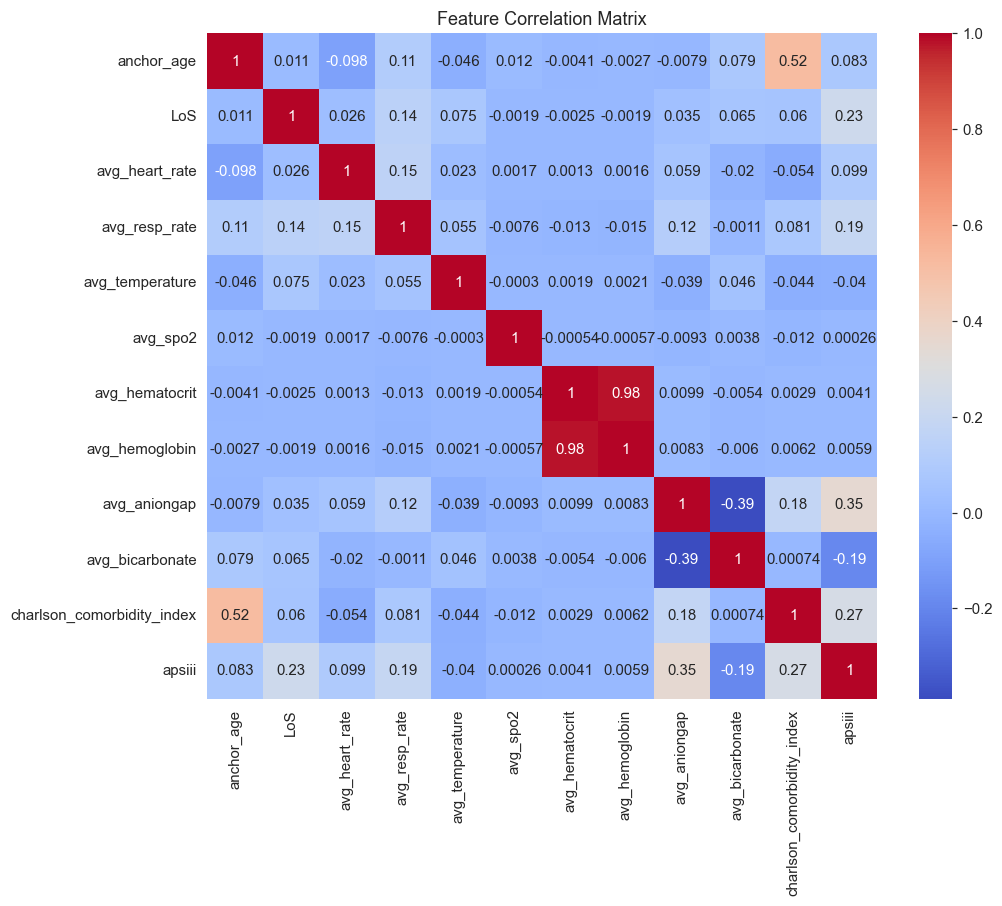

In [59]:
# Calculate the correlation matrix
corr_matrix = X.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

# Optionally, identify features with high correlation to drop (e.g., > 0.8)


#### K-means Clustering

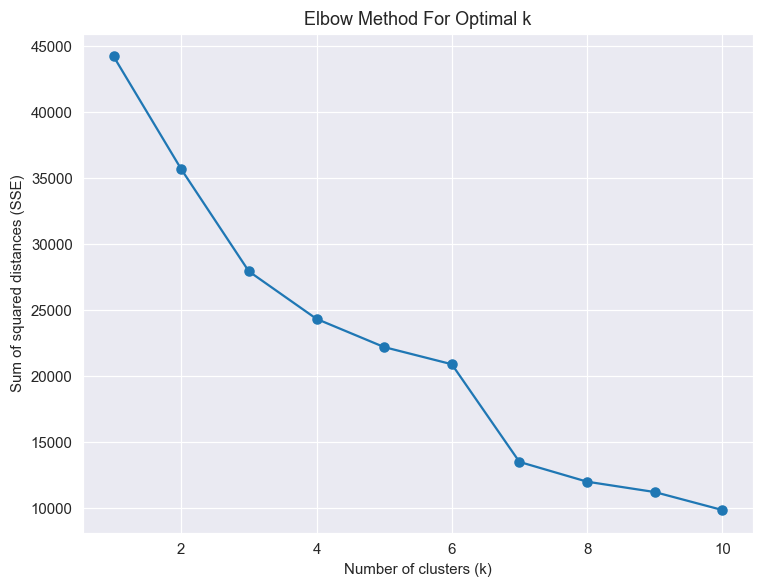

In [60]:
# Selecting relevant features for clustering
features = ['anchor_age', 'avg_bicarbonate', 'charlson_comorbidity_index', 'avg_hemoglobin', 'avg_spo2']

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[features])

# Elbow method to find the optimal number of clusters
sum_squared_distance = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    sum_squared_distance.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), sum_squared_distance, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances (SSE)')
plt.show()

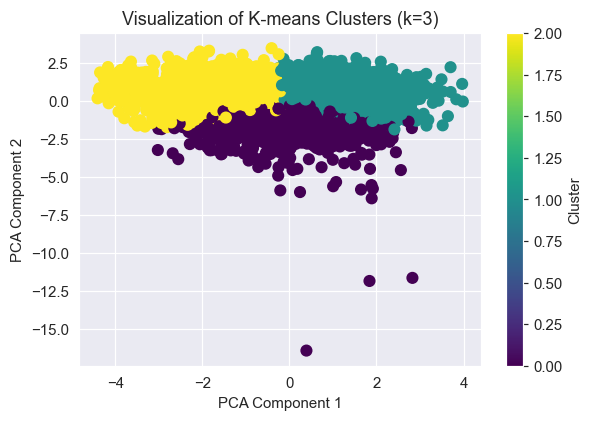

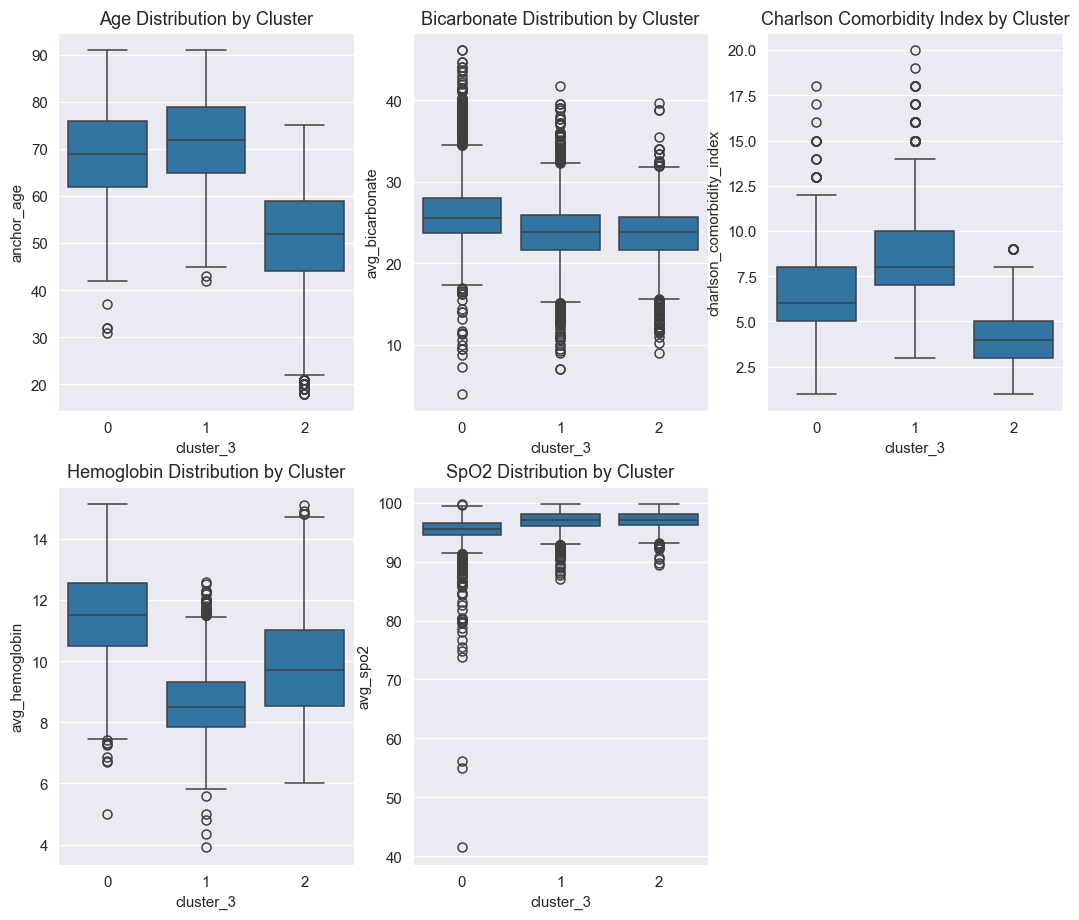

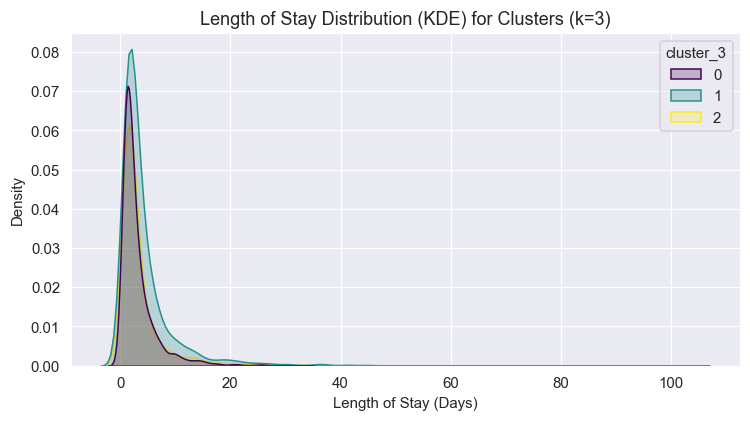

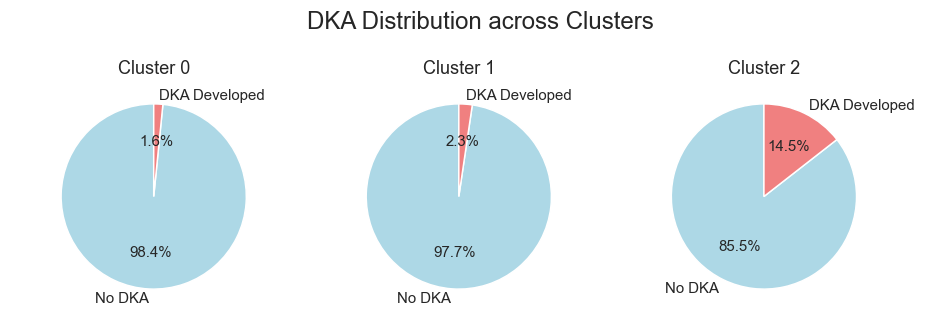

In [61]:
# Remove outliers based on the 99th percentile
for feature in ['avg_hemoglobin', 'avg_spo2']:
    upper_limit = data[feature].quantile(0.99)
    data = data[data[feature] <= upper_limit]

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[features])
k_values = [3]

# Do dimensionality reduction for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)


for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=114514)
    clusters = kmeans.fit_predict(scaled_features)
    
    data[f'cluster_{k}'] = clusters
    
    # PCA-based scatter plot for visualizing clusters
    plt.figure(figsize=(6, 4))
    plt.scatter(pca_components[:, 0], pca_components[:, 1], c=clusters, cmap='viridis', s=50)
    plt.title(f'Visualization of K-means Clusters (k={k})')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(label='Cluster')
    plt.show()

    # Boxplot to visualize the difference in properties across clusters
    custom_titles = {
        'anchor_age': 'Age Distribution by Cluster',
        'avg_bicarbonate': 'Bicarbonate Distribution by Cluster',
        'avg_hemoglobin': 'Hemoglobin Distribution by Cluster',
        'avg_spo2': 'SpO2 Distribution by Cluster',
        'charlson_comorbidity_index': 'Charlson Comorbidity Index by Cluster'
    }

    # Plot the boxplots after removing outliers
    plt.figure(figsize=(12, 10))
    for i, feature in enumerate(features):
        plt.subplot(2, 3, i+1)
        sns.boxplot(x=f'cluster_{k}', y=feature, data=data)
        plt.title(custom_titles.get(feature, f'{feature} Distribution across Clusters (k={k})'))

    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=data, x='LoS', hue=f'cluster_{k}', fill=True, palette='viridis')
    plt.title(f'Length of Stay Distribution (KDE) for Clusters (k={k})')
    plt.xlabel('Length of Stay (Days)')
    plt.ylabel('Density')

    dka_distribution = data.groupby(f'cluster_{k}')['developed_dka'].value_counts(normalize=True).unstack()
    
        # Create a figure with subplots (one row and as many columns as clusters)
    fig, axes = plt.subplots(1, len(dka_distribution.index), figsize=(9, 3))  # 1 row, N columns

    # Plot pie charts for each cluster in the same row
    for idx, cluster in enumerate(dka_distribution.index):
        labels = ['No DKA', 'DKA Developed']
        sizes = dka_distribution.loc[cluster].values
        axes[idx].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
        axes[idx].set_title(f'Cluster {cluster}')
        axes[idx].axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle

    plt.suptitle(f'DKA Distribution across Clusters', fontsize=16)
    plt.tight_layout()
    plt.show()


### 3. Model Training

In [62]:
from sklearn.utils import resample
data['cluster_label'] = data['cluster_3']


# Separate the data based on the 'developed_dka' column
dka_0 = data[data['developed_dka'] == 0]  # Class 0
dka_1 = data[data['developed_dka'] == 1]  # Class 1

# Sample 1000 rows from class 0 (from 8188 available)
train_dka_0 = dka_0.sample(3000, random_state=142)

train_dka_1 = dka_1.sample(300, random_state=1542)

# For class 1 (with 484 records), oversample to 2000 using resampling
train_dka_1 = resample(train_dka_1, replace=True, n_samples=3000, random_state=114514)

# Combine both samples to form the balanced training set
train_data = pd.concat([train_dka_0, train_dka_1])

# Use the entire dataset for validation
validation_data = data.copy()

# Display the number of rows in the training and validation datasets
train_data_count = train_data.shape[0]
validation_data_count = validation_data.shape[0]

print("Training Data Size:", train_data_count)
print("Validation Data Size:", validation_data_count)


Training Data Size: 6000
Validation Data Size: 8672


In [63]:
data['cluster_label'] = data['cluster_3']
selected_columns = ['anchor_age', 'avg_bicarbonate', 'charlson_comorbidity_index', 'avg_spo2', 'cluster_label']

# Apply the selection function for both training and validation data
X_train = train_data[selected_columns]
X_validation = validation_data[selected_columns]

# Define the target variable (y)
y_train = train_data['developed_dka']
y_validation = validation_data['developed_dka']

In [64]:
# Initialize the RandomForest model
model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Train the model
model.fit(X_train, y_train)

# Predict the validation set
y_pred_rf = model.predict(X_validation)

# Evaluate the Random Forest model
accuracy_rf = accuracy_score(y_validation, y_pred_rf)
report_rf = classification_report(y_validation, y_pred_rf)

# Print results
print(f"Accuracy: {accuracy_rf:.2f}")
print("Classification Report:")
print(report_rf)

Accuracy: 0.97
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      8188
           1       0.74      0.80      0.77       484

    accuracy                           0.97      8672
   macro avg       0.87      0.89      0.88      8672
weighted avg       0.97      0.97      0.97      8672



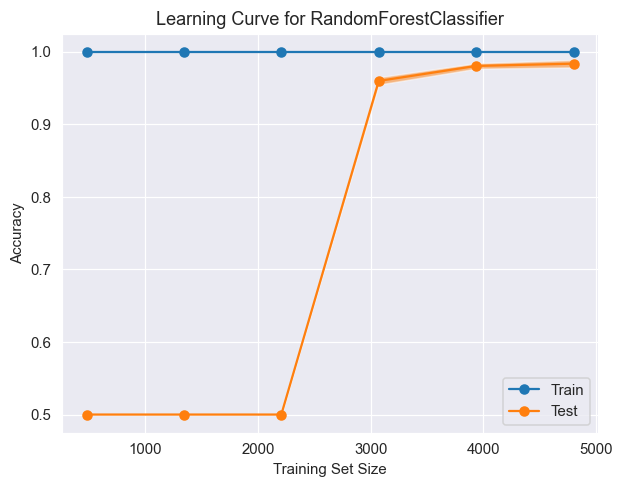

In [65]:
# Define common parameters for the learning curve
common_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 6),
    "cv": 5,
    "n_jobs": -1,
    "verbose": 0,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

model = RandomForestClassifier(random_state=46662)

# Calculate learning curve values (training and test scores)
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, train_sizes=common_params['train_sizes'], cv=common_params['cv'], n_jobs=common_params['n_jobs']
)

# Plot the learning curve using LearningCurveDisplay
LearningCurveDisplay.from_estimator(
    model, 
    X=X_train, 
    y=y_train, 
    train_sizes=common_params["train_sizes"], 
    cv=common_params["cv"], 
    n_jobs=common_params["n_jobs"],
    line_kw=common_params["line_kw"],
    std_display_style=common_params["std_display_style"],
    score_name=common_params["score_name"]
)

# Show the plot
plt.title("Learning Curve for RandomForestClassifier")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

In [66]:
log_reg_model = LogisticRegression(random_state=4662)
# Train Logistic Regression
log_reg_model.fit(X_train, y_train)
y_pred_log_reg = log_reg_model.predict(X_validation)
log_reg_accuracy = accuracy_score(y_validation, y_pred_log_reg)
log_reg_report = classification_report(y_validation, y_pred_log_reg)

print(f"Accuracy: {log_reg_accuracy:.2f}")
print("Classification Report:")
print(log_reg_report)


Accuracy: 0.81
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.82      0.89      8188
           1       0.19      0.72      0.30       484

    accuracy                           0.81      8672
   macro avg       0.58      0.77      0.60      8672
weighted avg       0.94      0.81      0.86      8672



### SVM

In [67]:
# Do not edit. These are the only imports permitted.
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import ndarray
from typing import List, Optional, Tuple, Callable
import random
import copy
import tqdm
from abc import ABC, abstractmethod
sns.set_style('darkgrid')
plt.rcParams['figure.dpi'] = 108
RND_SEED = 90

In [68]:
class SVM(ABC):
    """Base class for a support vector machine (SVM)"""
    
    def __init__(self):
        pass
        
    @abstractmethod
    def fit(self, X, y):        
        """Fit the model with the given training data.
        
        Parameters
        ----------        
        X : float numpy.ndarray, shape (n_samples, n_features)
            An array of training instances. 
        y : int {-1,1} numpy.ndarray, shape (n_samples,)
            Labels array relative to training instances.
        -------
        """
    
    @abstractmethod
    def predict(self, test_X):
        """Predict label for given test samples

        Parameters
        ----------        
        test_X : float numpy.ndarray, shape (n_samples, n_features)
            An array of test instances. 

        -------
        Return 
        y : int {-1,1} numpy.ndarray, shape (n_samples,)
            Predict labels array for test samples.
        """
        
    def evaluate(self, test_X, test_y):
        """Return the mean accuracy on the given test samples and labels.

        Parameters
        ----------        
        test_X : float numpy.ndarray, shape (n_samples, n_features)
            An array of test instances. 
        test_y : int {-1,1} numpy.ndarray, shape (n_samples,)
            Labels array relative to training instances.
        -------
        Return : float, mean accuracy

        """
            
        pred_y = self.predict(test_X)
        acc = (pred_y == test_y).sum() / len(test_y)
        return acc
    
    def visualize(self, X, y):
        """Plot data and decision surface of fitted model. 
        This function is adapted from 
        https://stackoverflow.com/questions/51297423/plot-scikit-learn-sklearn-svm-decision-boundary-surface

        Parameters
        ----------        
        X : float numpy.ndarray, shape (n_samples, n_features)
            An array of instances. 
        y : int {-1,1} numpy.ndarray, shape (n_samples,)
            Labels array relative to X.
        -------
        """
        y = np.array(y).squeeze()
        X = np.array(X)
        
        assert X.ndim == 2, "The shape of X must be (n_samples, n_features)"
        assert X.shape[0] == y.shape[0], "Inconsistent number of instances and labels"
        assert set(y) == set([1,-1]), "Labels must be 1 or -1"
        
        def make_meshgrid(x, y, h=0.5):
            x_min, x_max = x.min() - 1, x.max() + 1
            y_min, y_max = y.min() - 1, y.max() + 1
            xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
            return xx, yy

        def plot_contours(ax, clf, xx, yy, **params):
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            out = ax.contourf(xx, yy, Z, **params)
            return out
        
        fig, ax = plt.subplots()
        title = ('Decision surface of SVM')
        # Set-up grid for plotting.
        X0, X1 = X[:, 0], X[:, 1]
        xx, yy = make_meshgrid(X0, X1)

        plot_contours(ax, self, xx, yy, cmap=plt.cm.Pastel1)
        ax.scatter(X[y==-1,0], X[y==-1,1], color='b', label="$y = -1$")
        ax.scatter(X[y==1,0], X[y==1,1], color='r', label="$y = 1$")

        ax.set_ylabel('$x_1$')
        ax.set_xlabel('$x_2$')
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(title)
        ax.legend()
        plt.show()

In [69]:
class DualSVM(SVM):
    """Soft-margin SVM using dual formulation, training 
    with stochastic gradient ascent

    Parameters
    ----------
    eta : float
        Learning rate.
    C: float
        Regularization parameter.
    kernel: Kernel
        Kernel function
    """
    
    def __init__(self, eta, C, kernel=None):
        super().__init__()
        if kernel is None:
            def dot_product(u, v):
                return np.dot(u, v.T)
            self.kernel = dot_product
        else:
            self.kernel = kernel
            
        self.eta = eta
        self.C = C
        self.batch_size = 20
        self.model = "DualSoftMargin"
    
    def fit(self, X, y, iterations=100, class_weights={-1: 1, 1: 1}):
        """Fit the dual-formulation SVM model using stochastic gradient ascent."""
        super().fit(X=X, y=y)
        self.X = X
        self.y = y
        sample_num = self.X.shape[0]
        self.alphas = np.zeros(sample_num)
        index = np.arange(sample_num)
        np.random.seed(42)

        for i in range(iterations):
            np.random.shuffle(index)
            eta_t = self.eta / (i + 1)  # Optional learning rate decay

            for n in index:
                n = int(n)  # Convert np.int64 to standard Python int
                batch_index = np.random.choice(index, self.batch_size)
                xn, yn = X.iloc[n], y.iloc[n]

                # Compute gradient for the nth sample
                batch_alphas = self.alphas[batch_index]
                batch_labels = self.y.iloc[batch_index]
                batch_samples = self.X.iloc[batch_index]
                
                # Get the kernel output and ensure it's 1D for element-wise multiplication
                kernel_output = self.kernel(batch_samples, xn).flatten()


                weight = class_weights[yn]
                dot_product = np.dot(batch_alphas, batch_labels * self.kernel(batch_samples, xn))
                new_gradient = weight * (1 - yn * dot_product)

                # Update alphas
                new_alpha = self.alphas[n] + eta_t * new_gradient
                self.alphas[n] = np.clip(new_alpha, 0, self.C)

        # Calculate bias after fitting
        self.bias = self.get_bias()



    def predict(self, test_X):
        """Predict labels for test data."""
        super().predict(test_X=test_X)
        kernel_matrix = self.kernel(self.X, test_X)
        decision_function = np.dot(self.alphas * self.y, kernel_matrix) + self.bias
        return np.sign(decision_function)
    
    def primal_weights(self):
        """Compute weights based on alphas, assuming linear kernel."""
        if self.kernel.__name__ != 'dot_product':
            raise ValueError("Weights can only be computed for a linear kernel.")
        
        sample_num, feature_num = self.X.shape
        w = np.zeros(feature_num)
        for n in range(sample_num):
            w += self.alphas[n] * self.y[n] * self.X[n]
        return w
    
    def get_bias(self):
        """Compute the bias term."""
        sample_num = self.X.shape[0]
        sum_bias = 0.0
        count_sv = 50  # Number of support vectors

        for n in range(sample_num):
            if 0 < self.alphas[n] < self.C:  # Support vectors
                kernel_values = self.kernel(self.X.iloc[:], self.X.iloc[n])  # Pass actual data, not indexer
                sum_bias += self.y.iloc[n] - np.sum(self.alphas * self.y.values * kernel_values)
                count_sv += 1

        return sum_bias / count_sv if count_sv > 0 else 0.0
    
    def score(self, X, y):
        """Compute the accuracy of the model."""
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)
    
    def get_params(self, deep=True):
        """Get parameters for this estimator."""
        return {"eta": self.eta, "C": self.C, "kernel": self.kernel}

    def set_params(self, **params):
        """Set the parameters of this estimator."""
        for param, value in params.items():
            setattr(self, param, value)
        return self


In [70]:
data['cluster_label'] = data['cluster_3']
selected_columns = ['anchor_age', 'avg_bicarbonate', 'charlson_comorbidity_index', 'avg_spo2', 'cluster_label']

# Apply the selection function for both training and validation data
X_train = train_data[selected_columns]
X_validation = validation_data[selected_columns]

# Define the target variable (y)
y_train = train_data['developed_dka']
y_validation = validation_data['developed_dka']

y_train = y_train.replace({0: -1, 1: 1})
y_validation = y_validation.replace({0: -1, 1: 1})

In [71]:
# Initialize the DualSVM model (without a specific kernel; defaults to linear)
dsvm = DualSVM(eta=0.01, C=0.01)

# Fit the model to the DKA training data
dsvm.fit(X_train, y_train, iterations=100)

# Evaluate the model on the training data
accuracy = dsvm.evaluate(X_train, y_train)  # Assumes you have an evaluate method
print(f"Accuracy on training data: {round(accuracy, 4)}")




Accuracy on training data: 0.7497


In [72]:
class Kernel:
    """Kernel class to compute different types of kernels."""
    
    def __init__(self, kernel_type=None, **kwargs):
        if kernel_type == "linear":
            self.kernel = self.linear_kernel
        elif kernel_type == "poly":
            self.degree = kwargs.get('poly_degree', 3)
            self.sigma = kwargs.get('poly_offset', 1)
            self.kernel = self.poly_kernel
        elif kernel_type == "rbf":
            self.gamma = kwargs.get('gamma', 0.5)
            self.kernel = self.rbf_kernel
        elif kernel_type == "imq":
            self.c = kwargs.get('c', 1)
            self.kernel = self.imq_kernel
    
    def __call__(self, u, v):
        """Evaluate the kernel on a pair of inputs, possibly batched."""
        return self.kernel(u, v)
    
    def imq_kernel(self, u, v):
        # Convert Pandas Series or DataFrame to NumPy array if necessary
        if isinstance(u, pd.Series) or isinstance(u, pd.DataFrame):
            u = u.values
        if isinstance(v, pd.Series) or isinstance(v, pd.DataFrame):
            v = v.values
            
        if u.ndim == 1:
            u = u.reshape(1, -1)
        if v.ndim == 1:
            v = v.reshape(1, -1)

        # Ensure you're using NumPy's sum() function
        norm_rbf = np.sum(u**2, axis=1, keepdims=True) + np.sum(v**2, axis=1, keepdims=True).T - 2 * np.dot(u, v.T)
        return np.squeeze(1.0 / np.sqrt(norm_rbf + self.c**2))



Kernel Type: imq -------- Parameters: {'c': 0.01}
Performing cross-validation...
Cross-validation scores: [1.         0.99833333 0.995      1.         0.995      0.99166667
 1.         0.99833333 0.99833333 0.995     ]
Average cross-validation accuracy: 0.9972
Plotting learning curve...


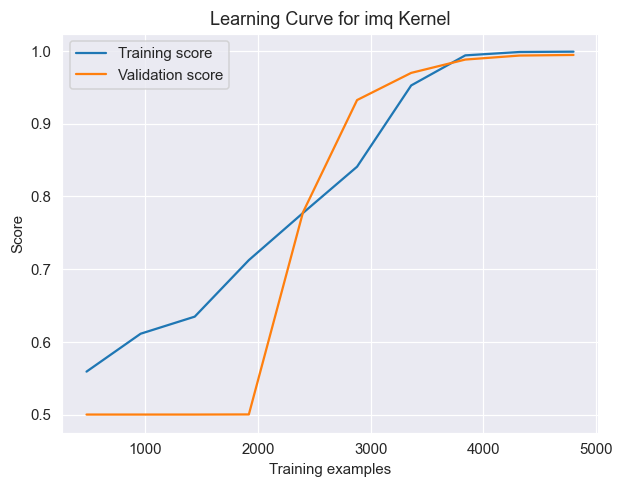

Training Accuracy: 0.9997
Validation Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

          -1       0.98      1.00      0.99      8188
           1       1.00      0.62      0.76       484

    accuracy                           0.98      8672
   macro avg       0.99      0.81      0.88      8672
weighted avg       0.98      0.98      0.98      8672



In [73]:
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold

# Define experimental kernel configurations
experimental_kernel = [
    #("rbf", {"gamma": 0.5}),
    ("imq", {"c": 0.01})
]

# Function to plot the learning curve
def plot_learning_curve(estimator, X, y, title="Learning Curve"):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure()
    plt.title(title)
    plt.plot(train_sizes, train_scores_mean, label="Training score")
    plt.plot(train_sizes, test_scores_mean, label="Validation score")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.show()

# Iterate through each kernel configuration
for kernel_type, parameters in experimental_kernel:
    print(f"\nKernel Type: {kernel_type} -------- Parameters: {parameters}")
    
    # Initialize the kernel and SVM model
    kernel = Kernel(kernel_type=kernel_type, **parameters)
    dsvm = DualSVM(eta=0.1, C=100, kernel=kernel)
    
    # Perform cross-validation
    print("Performing cross-validation...")
    skf = StratifiedKFold(n_splits=10)
    cross_val_scores = cross_val_score(dsvm, X_train, y_train, cv=skf, n_jobs=-1, scoring='accuracy')
    print(f"Cross-validation scores: {cross_val_scores}")
    print(f"Average cross-validation accuracy: {np.mean(cross_val_scores):.4f}")
    
    # Plot learning curve
    print("Plotting learning curve...")
    plot_learning_curve(dsvm, X_train, y_train, title=f"Learning Curve for {kernel_type} Kernel")

    # Fit the model on full training data
    dsvm.fit(X_train, y_train, iterations=100)
    
    # Evaluate on the training set
    train_accuracy = dsvm.evaluate(X_train, y_train)
    print(f"Training Accuracy: {round(train_accuracy, 4)}")

    # Predict the validation set
    y_pred_svm = dsvm.predict(X_validation)

    # Calculate validation accuracy
    svm_accuracy = accuracy_score(y_validation, y_pred_svm)
    print(f"Validation Accuracy: {svm_accuracy:.2f}")

    # Generate classification report
    svm_report = classification_report(y_validation, y_pred_svm)
    print("Classification Report:")
    print(svm_report)
